In [111]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


In [112]:
# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                # Extract record ID from the file path
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

In [113]:
# Helper function to load MMSE labels and demographic information
def load_labels(label_file):
    df = pd.read_csv(label_file)
    df['label'] = df['Class']  # Use 'Class' as the label
    return df.set_index('Record-ID')[['label', 'Age', 'Gender', 'Converted-MMSE']].to_dict(orient='index')


In [114]:
# Load data
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

# Load labels
label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

In [115]:
# Combine text data with demographic data
combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels:
        label_data = labels[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Age': label_data['Age'],
            'Gender': label_data['Gender'],
            'MMSE-Score': label_data['Converted-MMSE'],
            'Class': label_data['label']
        })

# Create a DataFrame from combined data
df = pd.DataFrame(combined_data)

# Encode categorical variables
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})  # Example encoding

# Drop rows with missing values in important columns
df.dropna(subset=['Text', 'Class', 'Age', 'Gender', 'MMSE-Score'], inplace=True)

# Split data into features (X) and labels (y)
X = df[['Text', 'Age', 'Gender', 'MMSE-Score']]
y = df['Class']

In [116]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train-Daten anzeigen
print("Trainingsdaten:")
print(pd.concat([X_train, y_train], axis=1))

# Test-Daten anzeigen
print("\nTestdaten:")
print(pd.concat([X_test, y_test], axis=1))


Trainingsdaten:
                                                  Text  Age  Gender  \
56   Pat: Er, two children on a stool trying to tak...   72     0.0   
139  Pat: Um, the children are um getting up to mis...   66     1.0   
124  Pat: There is a woman washing up, the sink is ...   58     1.0   
129  Pat: OK. Well there’s a lady washing dishes at...   66     0.0   
128  Pat: It’s a (1 second) picture of a family in ...   71     0.0   
..                                                 ...  ...     ...   
72   Pat: (1 second) OK, so I can see (sighs) I can...   30     1.0   
107  Pat: (3 seconds) Er, it looks like a sunny day...   66     1.0   
14   Pat: (8 seconds) Um, a woman washing dishes bu...   74     0.0   
93   Pat: (2 seconds) This appears to be a picture ...   69     1.0   
103  Pat: (1 second) Yeah, it’s a, it appears to be...   50     0.0   

     MMSE-Score Class  
56         30.0    HC  
139        30.0    HC  
124        30.0    HC  
129        30.0    HC  
128        

In [117]:


# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Text'),  # Text features using TF-IDF
        ('numeric', MinMaxScaler(), ['Age', 'MMSE-Score']),  # Scale numeric features
        ('gender', 'passthrough', ['Gender'])  # Use Gender as is (0/1)
    ]
)

# Create a pipeline for feature extraction and classification
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', MultinomialNB())    # Naive Bayes classifier
])

In [118]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text', TfidfVectorizer(),
                                                  'Text'),
                                                 ('numeric', MinMaxScaler(),
                                                  ['Age', 'MMSE-Score']),
                                                 ('gender', 'passthrough',
                                                  ['Gender'])])),
                ('classifier', MultinomialNB())])

              precision    recall  f1-score   support

    Dementia       0.00      0.00      0.00         4
          HC       0.47      1.00      0.64        15
         MCI       0.00      0.00      0.00        13

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32



C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin

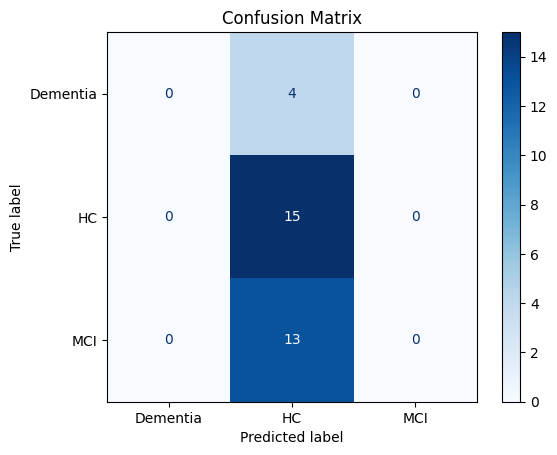

ValueError: array length 32 does not match index length 47

In [119]:
# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save predictions
predictions_df = pd.DataFrame({
    'Record-ID': df.iloc[X_test.index]['Record-ID'],
    'Text': X_test['Text'],
    'Age': X_test['Age'],
    'Gender': X_test['Gender'],
    'MMSE-Score': X_test['MMSE-Score'],
    'True Label': y_test,
    'Predicted Label': y_pred
})

predictions_df.to_csv("predictions_with_features.csv", index=False)
print("Predictions saved to 'predictions_with_features.csv'.")